## Import Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Bidirectional, GRU, Dropout, SpatialDropout2D, Dense, Conv2D, MaxPooling2D, Concatenate, Dense, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model

In [4]:
# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


### Set Numpy, Python, and TF seeds

In [2]:
spatial_input_size = (224,224,3)
temporal_input_size = (320, 240, 1)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


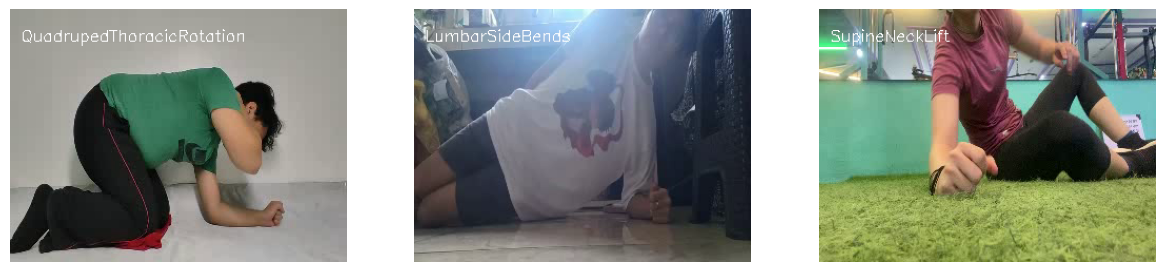

In [3]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw2')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw2/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw2/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH =  96, 96 #for rgb/1st stream

SEQUENCE_LENGTH = 30

DATASET_DIR = r"D:\MAPUA\CNN_GRU_usingRGBOF\downgraded_raw2"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [5]:
def frames_extraction_RGB(video_path):
    """Extract frames from video and return normalized RGB frames"""
    frames_list1 = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the position of the next frame to read
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        if not success:
            break
        
        # Convert BGR (default in OpenCV) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize to target dimensions and normalize to [0, 1]
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0
        
        frames_list1.append(normalized_frame)
    
    video_reader.release()
    
    # Determine a padding frame if fewer than SEQUENCE_LENGTH frames were extracted
    if frames_list1:
        pad_frame = np.zeros_like(frames_list1[0])
    else:
        pad_frame = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
    
    # Pad the list to ensure the length is SEQUENCE_LENGTH
    while len(frames_list1) < SEQUENCE_LENGTH:
        frames_list1.append(pad_frame)
    
    return frames_list1


2nd CNN Stream

###### Get optical flow frames

In [6]:
def compute_optical_flow(prev_frame, next_frame):
    """
    Compute optical flow using the Lucas-Kanade method between two frames.
    
    Returns:
        good_old: Array of points from the previous frame.
        good_new: Array of corresponding points from the next frame.
    """
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Parameters for Shi-Tomasi corner detection (good features to track)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    
    # Detect features in the previous frame
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []

    # Calculate optical flow (find corresponding points in the next frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Ensure valid output and select good points based on the status array
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    """
    Create Motion Energy Image (MEI) and Motion History Image (MHI) from optical flow vectors.
    
    Args:
        flow: Tuple containing (good_old, good_new) points.
        shape: Tuple defining the output image size (height, width).
        tau: Time constant for motion decay in the MHI.
        
    Returns:
        mei: The Motion Energy Image (binary representation of motion).
        mhi: The Motion History Image (captures motion intensity with decay).
    """
    # Initialize MEI and MHI as zero arrays
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)

    # Iterate over each pair of corresponding points to draw motion vectors
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw a line for the motion on the MEI (binary, using a fixed thickness)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw the same line on the MHI (this will later be decayed over time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Apply decay to the MHI (simulate motion fading over time)
    mhi[mhi > 0] -= 255 / tau  
    mhi[mhi < 0] = 0  # Clip negative values to 0

    return mei, mhi

def frames_extraction_OF(video_path, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    """
    Extracts Motion Energy Images (MEI) from a video by computing optical flow between frame pairs.
    
    Args:
        video_path: Path to the video file.
        SEQUENCE_LENGTH: Number of frame pairs (and thus MEI images) to extract.
        IMAGE_HEIGHT: Target height for resizing frames.
        IMAGE_WIDTH: Target width for resizing frames.
    
    Returns:
        A 4D NumPy array of shape (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
        containing the normalized MEI images.
    """
    frames_list2 = []

    # Open the video file
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return frames_list2

    # Total frames and skip window calculation for even sampling
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate over the video using the skip window to select frame pairs
    for frame_counter in range(0, video_frames_count - skip_frames_window, skip_frames_window):
        # Read the previous frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, prev_frame = video_reader.read()
        if not success:
            break

        # Read the next frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter + skip_frames_window)
        success, next_frame = video_reader.read()
        if not success:
            break

        # Resize frames to target dimensions. Note: cv2.resize expects (width, height)
        prev_frame_resized = cv2.resize(prev_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        next_frame_resized = cv2.resize(next_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Compute optical flow between the two frames
        good_old, good_new = compute_optical_flow(prev_frame_resized, next_frame_resized)

        # If no valid optical flow vectors were found, skip this pair
        if len(good_old) == 0 or len(good_new) == 0:
            print(f"Warning: No optical flow vectors found for frames {frame_counter} and {frame_counter + skip_frames_window}.")
            continue

        # Create the Motion Energy Image (MEI) from the optical flow vectors
        mei, _ = create_mei_mhi((good_old, good_new), (IMAGE_HEIGHT, IMAGE_WIDTH), tau=10)

        # Normalize the MEI to 0-255 and convert to an 8-bit image for visualization
        mei_norm = cv2.normalize(mei, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Expand dimensions to add a channel axis (resulting in shape: H x W x 1)
        mei_norm = np.expand_dims(mei_norm, axis=-1)

        # Append the normalized MEI image to the list
        frames_list2.append(mei_norm)

    # Release the video capture
    video_reader.release()

    # If fewer than SEQUENCE_LENGTH frames were extracted, pad with zero-frames
    while len(frames_list2) < SEQUENCE_LENGTH:
        frames_list2.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8))

    # If more than SEQUENCE_LENGTH frames were collected, truncate the list
    if len(frames_list2) > SEQUENCE_LENGTH:
        frames_list2 = frames_list2[:SEQUENCE_LENGTH]

    # Convert the list of frames to a 4D NumPy array
    frames_list2 = np.stack(frames_list2, axis=0)

    return frames_list2

## Dataset Creation

1st Stream

In [7]:
def create_dataset_1st():
    """Creates the dataset for the first (RGB) stream with flipping and rotation augmentations."""
    features1 = []
    labels1 = []
    video_files_paths1 = []
    
    # Create an ImageDataGenerator with rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Allow rotations up to 15 degrees.
        horizontal_flip=True,     # Enable horizontal flipping.
        fill_mode='nearest'       # Strategy to fill in newly created pixels.
    )
    
    # Iterate over each class in the dataset.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        # Process each video file in the current class directory.
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the original frames using the defined function.
                frames = frames_extraction_RGB(video_file_path)
                
                # Only proceed if the number of extracted frames equals SEQUENCE_LENGTH.
                if len(frames) == SEQUENCE_LENGTH:
                    # Add the original frames to the features list.
                    features1.append(frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path)
                    
                    # Create an augmented version of the frames.
                    augmented_frames = []
                    # Generate a random seed that will be used for every frame in the sequence
                    # to ensure a consistent transformation across the entire video.
                    seed = np.random.randint(1000)
                    
                    for frame in frames:
                        # Expand dimensions to match the input shape expected by ImageDataGenerator.
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        # Generate the augmented frame.
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented frames as a separate sample.
                    features1.append(augmented_frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path + '_aug')
                else:
                    print(f"Warning: {video_file_path} did not yield {SEQUENCE_LENGTH} frames.")
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert lists to NumPy arrays.
    features1 = np.array(features1)
    labels1 = np.array(labels1)
    
    return features1, labels1, video_files_paths1


In [8]:
output_folder = "rgb_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create your dataset for the RGB stream
features1, labels1, video_files_paths1 = create_dataset_1st()

# Display dataset information
print(f"Features shape: {features1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths1)}")

# Save the features, labels, and video paths into .npy files inside 'rgb_data'
np.save(os.path.join(output_folder, "features1.npy"), features1)
np.save(os.path.join(output_folder, "labels1.npy"), labels1)
np.save(os.path.join(output_folder, "video_files_paths1.npy"), video_files_paths1)


Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (334, 30, 96, 96, 3)
Labels shape: (334,)
Number of videos (including augmented): 334


In [9]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1, num_classes=len(CLASSES_LIST))

In [10]:
# Display the converted labels
unique_labels1, counts1 = np.unique(labels1, return_counts=True)
for label, count in zip(unique_labels1, counts1):
    print(f"Label {label}: {count} instances")

Label 0: 116 instances
Label 1: 112 instances
Label 2: 106 instances


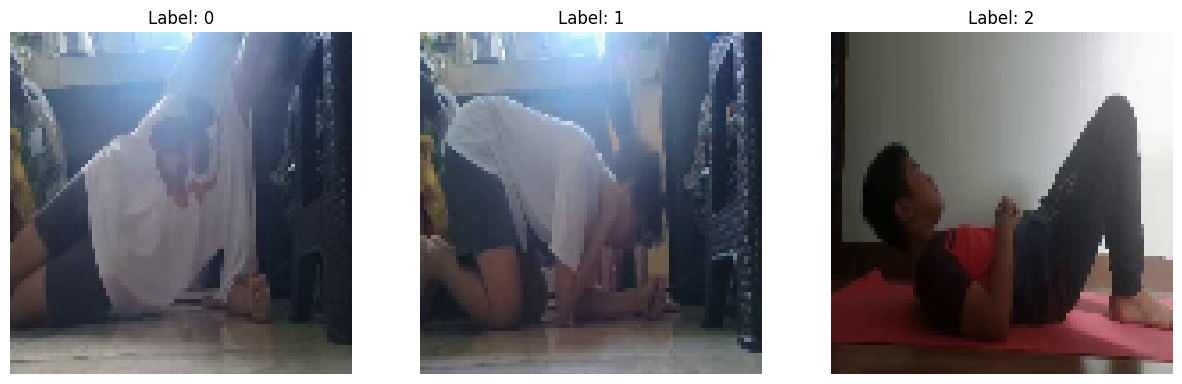

In [11]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels1):
    # Find the first index of the current label
    index = np.where(labels1 == label)[0][0]

#Extract the corresponding video frames
    frames = features1[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Show Sample Augmeted Frames

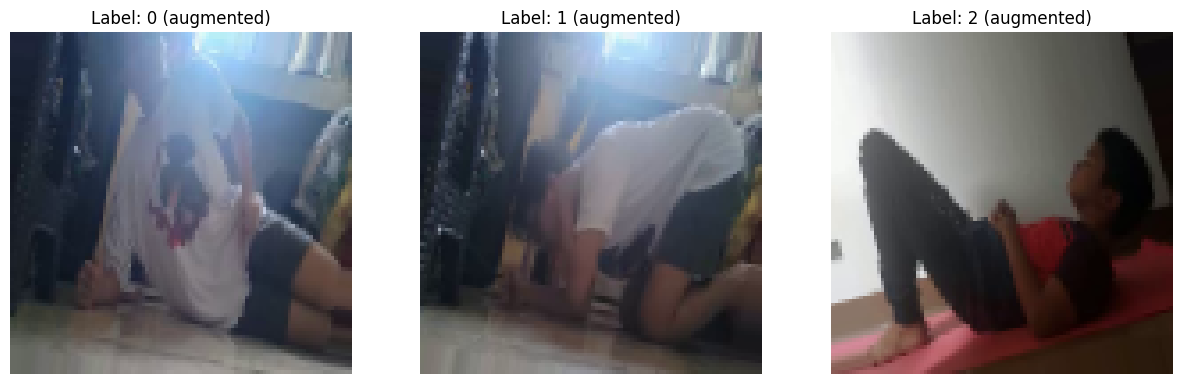

In [12]:
plt.figure(figsize=(15, 5))

# Get unique labels (assumes labels1 is a NumPy array)
unique_labels = np.unique(labels1)

for i, label in enumerate(unique_labels):
    # Find all indices where the sample has the current label and is an augmented sample.
    # We check if '_aug' is in the corresponding file path.
    augmented_indices = [
        j for j, (lab, path) in enumerate(zip(labels1, video_files_paths1))
        if lab == label and '_aug' in path
    ]
    
    # If no augmented sample is found, use the first original sample.
    if len(augmented_indices) == 0:
        print(f"No augmented sample found for label {label}. Using original sample.")
        index = np.where(labels1 == label)[0][0]
    else:
        index = augmented_indices[0]
    
    # Extract the video frames for the chosen sample.
    frames = features1[index]
    
    # Select a random frame from the sequence.
    random_frame = frames[np.random.randint(0, len(frames))]
    
    # Plot the frame.
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label} (augmented)")
    plt.axis('off')

plt.show()


2nd Stream

In [13]:
def create_dataset_2nd():
    """Creates the dataset with only flipping and rotation augmentations for the optical flow stream."""
    features2 = []
    labels2 = []
    video_files_paths2 = []
    
    # Create an ImageDataGenerator for applying rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Rotate images up to 15 degrees.
        horizontal_flip=True,     # Apply horizontal flipping.
        fill_mode='nearest'       # Define how to fill pixels when transformations create new empty areas.
    )
    
    # Loop over each class directory
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the optical flow frames using the frames_extraction_OF function.
                # Note: The parameters (SEQUENCE_LENGTH, 320, 240) specify the number of frames and the target dimensions.
                frames = frames_extraction_OF(video_file_path, SEQUENCE_LENGTH, 320, 240)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Save the original optical flow frames.
                    features2.append(frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path)
                    
                    # Create an augmented version of the optical flow frames.
                    augmented_frames = []
                    seed = np.random.randint(1000)  # Use the same seed for all frames to maintain consistency across the sequence.
                    
                    for frame in frames:
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented sample.
                    features2.append(augmented_frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path + '_aug')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert the collected lists to NumPy arrays.
    features2 = np.array(features2)
    labels2 = np.array(labels2)
    
    return features2, labels2, video_files_paths2


In [14]:
# Create the folder 'opticalflow_data' if it doesn't already exist
output_folder = "opticalflow_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create your dataset for the optical flow stream
features2, labels2, video_files_paths2 = create_dataset_2nd()

# Display dataset information
print(f"Features shape: {features2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths2)}")

# Save the features, labels, and video paths into .npy files inside 'opticalflow_data'
np.save(os.path.join(output_folder, "features2.npy"), features2)
np.save(os.path.join(output_folder, "labels2.npy"), labels2)
np.save(os.path.join(output_folder, "video_files_paths2.npy"), video_files_paths2)

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (334, 30, 320, 240, 1)
Labels shape: (334,)
Number of videos (including augmented): 334


In [15]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2,num_classes=len(CLASSES_LIST))

In [16]:
# Display the converted labels 
unique_labels2, counts2 = np.unique(labels2, return_counts=True)
for label, count in zip(unique_labels2, counts2):
    print(f"Label {label}: {count} instances")

Label 0: 116 instances
Label 1: 112 instances
Label 2: 106 instances


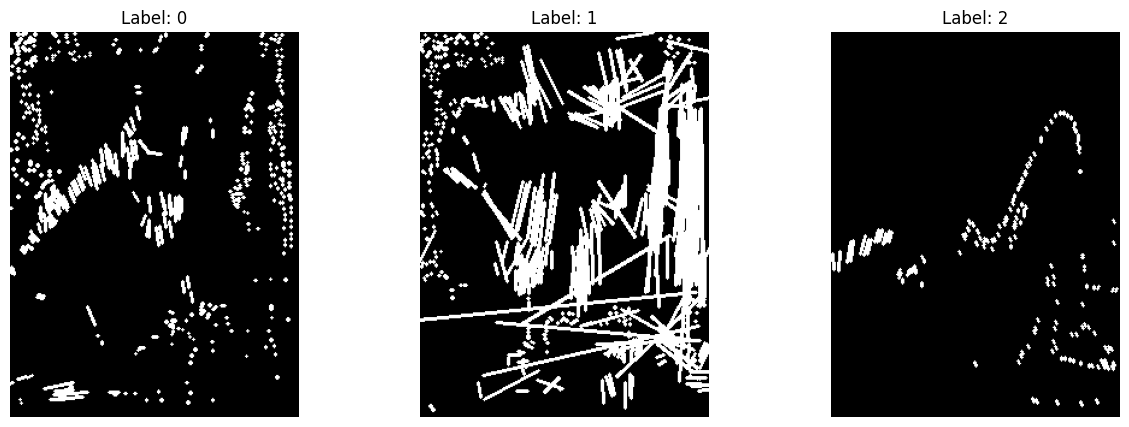

In [17]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels2):
    # Find the first index of the current label
    index = np.where(labels2 == label)[0][0]

#Extract the corresponding video frames
    frames = features2[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame, cmap="grey")
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Show Sample Augmented Frames:

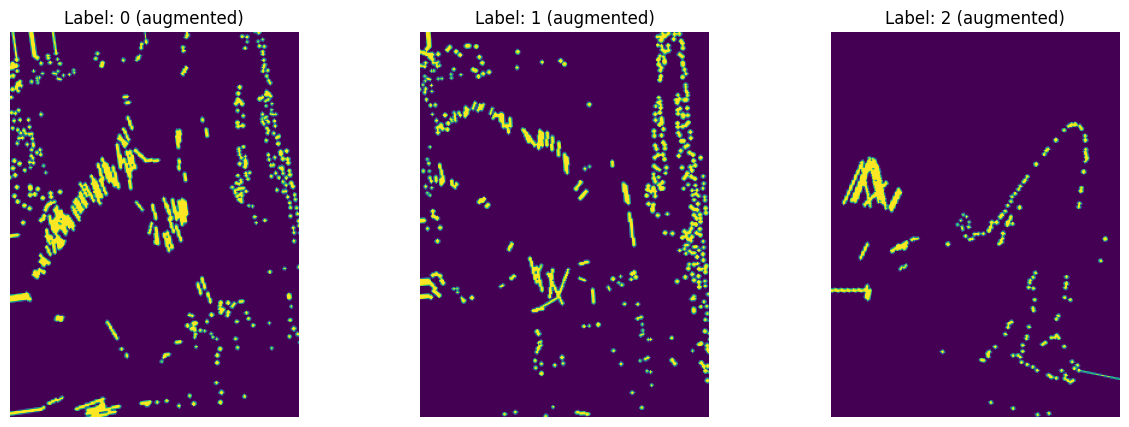

In [18]:
plt.figure(figsize=(15, 5))

# Get unique labels (assumes labels1 is a NumPy array)
unique_labels = np.unique(labels2)

for i, label in enumerate(unique_labels):
    # Find all indices where the sample has the current label and is an augmented sample.
    # We check if '_aug' is in the corresponding file path.
    augmented_indices = [
        j for j, (lab, path) in enumerate(zip(labels2, video_files_paths2))
        if lab == label and '_aug' in path
    ]
    
    # If no augmented sample is found, use the first original sample.
    if len(augmented_indices) == 0:
        print(f"No augmented sample found for label {label}. Using original sample.")
        index = np.where(labels1 == label)[0][0]
    else:
        index = augmented_indices[0]
    
    # Extract the video frames for the chosen sample.
    frames = features2[index]
    
    # Select a random frame from the sequence.
    random_frame = frames[np.random.randint(0, len(frames))]
    
    # Plot the frame.
    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label} (augmented)")
    plt.axis('off')

plt.show()


## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [19]:
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train1, features_val1, labels_train1, labels_val1 = train_test_split(
    features_train1, labels_train1, test_size=0.20, shuffle=True, random_state=seed_constant
)
output_folder = "rgb_data"
# Save the features arrays to the rgb_data folder.
np.save(os.path.join(output_folder, "features_train1.npy"), features_train1)
np.save(os.path.join(output_folder, "features_val1.npy"), features_val1)
np.save(os.path.join(output_folder, "features_test1.npy"), features_test1)

# Optionally, save the corresponding labels as well.
np.save(os.path.join(output_folder, "labels_train1.npy"), labels_train1)
np.save(os.path.join(output_folder, "labels_val1.npy"), labels_val1)
np.save(os.path.join(output_folder, "labels_test1.npy"), labels_test1)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train1)}")
print(f"Number of validation samples: {len(features_val1)}")
print(f"Number of testing samples: {len(features_test1)}")


Number of training samples: 213
Number of validation samples: 54
Number of testing samples: 67


For 2nd Stream (OF Data)

In [20]:
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train2, features_val2, labels_train2, labels_val2 = train_test_split(
    features_train2, labels_train2, test_size=0.20, shuffle=True, random_state=seed_constant
)
output_folder = "opticalflow_data"
# Save the features arrays to the rgb_data folder.
np.save(os.path.join(output_folder, "features_train2.npy"), features_train2)
np.save(os.path.join(output_folder, "features_val2.npy"), features_val2)
np.save(os.path.join(output_folder, "features_test2.npy"), features_test2)

# Optionally, save the corresponding labels as well.
np.save(os.path.join(output_folder, "labels_train2.npy"), labels_train2)
np.save(os.path.join(output_folder, "labels_val2.npy"), labels_val2)
np.save(os.path.join(output_folder, "labels_test2.npy"), labels_test2)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train2)}")
print(f"Number of validation samples: {len(features_val2)}")
print(f"Number of testing samples: {len(features_test2)}")

Number of training samples: 213
Number of validation samples: 54
Number of testing samples: 67


## Implement 2stream Model

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Bidirectional, GRU, Dropout,SpatialDropout2D, Dense, Conv2D, MaxPooling2D, Concatenate, Dense, Dropout, Lambda
from tensorflow.keras.models import Model

In [22]:
# Define input shapes
rgb_input_shape = (features1.shape[1:])  # (Time steps, Height, Width, Channels)
of_input_shape = (features2.shape[1:])   # (Time steps, Height, Width, OF Channels)
num_classes = 3 # Example: 10 action classes

print(rgb_input_shape)
print(of_input_shape)

(30, 96, 96, 3)
(30, 320, 240, 1)


Define the RGB CNN Architecture

In [23]:
def create_rgb_stream_model(seq_length=30, input_shape=(96, 96, 3), gru_units=64, dropout_rate=0.5, feature_dim=64):
    """Creates the RGB stream model (as provided)."""
    base_cnn = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_cnn.trainable = False
    rgb_input = tf.keras.Input(shape=(seq_length,) + input_shape, name="rgb_input")
    x = tf.keras.layers.TimeDistributed(base_cnn, name="time_distributed_cnn")(rgb_input)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D(), name="time_distributed_gap")(x)
    x = tf.keras.layers.GRU(gru_units, return_sequences=False, name="gru_layer")(x)
    x = tf.keras.layers.Dropout(dropout_rate, name="gru_dropout")(x)
    output = tf.keras.layers.Dense(feature_dim, activation='relu', name="rgb_feature_vector")(x)
    model = tf.keras.Model(inputs=rgb_input, outputs=output, name="RGB_Stream_Model")
    return model

In [24]:
# Create the RGB model
rgb_model = create_rgb_stream_model()
rgb_model.summary()

Model: "RGB_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 30, 96, 96, 3)]   0         
                                                                 
 time_distributed_cnn (TimeD  (None, 30, 3, 3, 1280)   2257984   
 istributed)                                                     
                                                                 
 time_distributed_gap (TimeD  (None, 30, 1280)         0         
 istributed)                                                     
                                                                 
 gru_layer (GRU)             (None, 64)                258432    
                                                                 
 gru_dropout (Dropout)       (None, 64)                0         
                                                                 
 rgb_feature_vector (Dense)  (None, 64)           

Define the Optical Flow CNN architecture

In [26]:
def create_optical_flow_stream_model(seq_length=30, input_shape=(320, 240, 1), gru_units=64, dropout_rate=0.5, feature_dim=64):
    """Creates the optical flow stream model (as provided)."""
    flow_input = tf.keras.Input(shape=(seq_length,) + input_shape, name="flow_input")
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'), name="td_conv1")(flow_input)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)), name="td_pool1")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'), name="td_conv2")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)), name="td_pool2")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'), name="td_conv3")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)), name="td_pool3")(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D(), name="td_gap")(x)
    x = tf.keras.layers.GRU(gru_units, return_sequences=False, name="gru_flow")(x)
    x = tf.keras.layers.Dropout(dropout_rate, name="gru_flow_dropout")(x)
    output = tf.keras.layers.Dense(feature_dim, activation='relu', name="flow_feature_vector")(x)
    model = tf.keras.Model(inputs=flow_input, outputs=output, name="OpticalFlow_Stream_Model")
    return model

In [27]:
optical_flow_model = create_optical_flow_stream_model()  # Corrected call
optical_flow_model.summary()

Model: "OpticalFlow_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flow_input (InputLayer)     [(None, 30, 320, 240, 1)  0         
                             ]                                   
                                                                 
 td_conv1 (TimeDistributed)  (None, 30, 320, 240, 16)  160       
                                                                 
 td_pool1 (TimeDistributed)  (None, 30, 160, 120, 16)  0         
                                                                 
 td_conv2 (TimeDistributed)  (None, 30, 160, 120, 32)  4640      
                                                                 
 td_pool2 (TimeDistributed)  (None, 30, 80, 60, 32)    0         
                                                                 
 td_conv3 (TimeDistributed)  (None, 30, 80, 60, 64)    18496     
                                          

## Feature extractor for late fusion

In [28]:
def create_late_fusion_feature_extractor(rgb_model, optical_flow_model):
    """
    Creates a Keras Model that extracts the concatenated features from the
    RGB and Optical Flow streams *before* the final classification layers.
    This model is used to provide input to the One-Class SVM.

    Args:
        rgb_model: The trained RGB stream model.
        flow_model: The trained Optical Flow stream model.

    Returns:
        A Keras Model with the same inputs as the late fusion model, but with
        the output being the concatenated features.
    """
    rgb_input = rgb_model.input  # Get the input layer of the RGB stream
    flow_input = optical_flow_model.input  # Get the input layer of the OF stream

    rgb_features = rgb_model.output  # Get the output of the RGB stream
    flow_features = optical_flow_model.output  # Get the output of the OF stream

    rgb_features = BatchNormalization(name="rgb_bn")(rgb_features) # Get Batch normalized
    flow_features = BatchNormalization(name="flow_bn")(flow_features)

    # Concatenate the features (this is where the fusion happens)
    fused_features = Concatenate(name='fusion_concat')([rgb_features, flow_features])

    # Create the feature extraction model
    feature_extractor = Model(inputs=[rgb_input, flow_input], outputs=fused_features, name='feature_extractor')
    return feature_extractor

In [29]:
feature_extractor = create_late_fusion_feature_extractor(rgb_model, optical_flow_model)
feature_extractor.summary()

Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flow_input (InputLayer)        [(None, 30, 320, 24  0           []                               
                                0, 1)]                                                            
                                                                                                  
 td_conv1 (TimeDistributed)     (None, 30, 320, 240  160         ['flow_input[0][0]']             
                                , 16)                                                             
                                                                                                  
 td_pool1 (TimeDistributed)     (None, 30, 160, 120  0           ['td_conv1[0][0]']               
                                , 16)                                             

## Late  Fusion

In [30]:
def create_late_fusion_model(rgb_model, flow_model, num_classes, 
                                      fusion_dropout=0.5, dense_units=128):
    """
    Creates an improved late fusion model that combines the feature outputs from the 
    RGB stream and the Optical Flow stream models.
    """
    
    # Get the inputs from each branch.
    rgb_input = rgb_model.input
    flow_input = flow_model.input
    
    # Extract the feature outputs from each stream.
    rgb_features = rgb_model.output 
    flow_features = flow_model.output 
    
    # Apply Batch Normalization to each modality's features.
    rgb_features = BatchNormalization(name="rgb_bn")(rgb_features)
    flow_features = BatchNormalization(name="flow_bn")(flow_features)
    
    # Fuse the features using concatenation.
    fused_features = Concatenate(name='fusion_concat')([rgb_features, flow_features])
    
    # First transformation block after fusion.
    x = Dropout(fusion_dropout, name='fusion_dropout_1')(fused_features)
    x = Dense(dense_units, name='fusion_dense_1')(x)
    x = BatchNormalization(name='fusion_bn_1')(x)
    x = Activation('relu', name='fusion_act_1')(x)
    
    # Second transformation block for added non-linearity.
    x = Dropout(fusion_dropout, name='fusion_dropout_2')(x)
    x = Dense(dense_units // 2, name='fusion_dense_2')(x)
    x = BatchNormalization(name='fusion_bn_2')(x)
    x = Activation('relu', name='fusion_act_2')(x)
    
    # Final classification layer.
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[rgb_input, flow_input], outputs=outputs, name='Improved_Late_Fusion_Model')
    return model

##### Display Architecture

In [31]:
num_classes = 3
late_fusion_model = create_late_fusion_model(rgb_model, optical_flow_model, num_classes)
late_fusion_model.summary()

Model: "Improved_Late_Fusion_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flow_input (InputLayer)        [(None, 30, 320, 24  0           []                               
                                0, 1)]                                                            
                                                                                                  
 td_conv1 (TimeDistributed)     (None, 30, 320, 240  160         ['flow_input[0][0]']             
                                , 16)                                                             
                                                                                                  
 td_pool1 (TimeDistributed)     (None, 30, 160, 120  0           ['td_conv1[0][0]']               
                                , 16)                                    

## Train the Model

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
# Compile the late fusion model.
late_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Set up early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model without using ModelCheckpoint.
history = late_fusion_model.fit(
    [features_train1, features_train2],  # List of inputs for the two streams.
    labels_train1,                        # One-hot encoded labels.
    validation_data=([features_val1, features_val2], labels_val1),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping]
)

# Save the final model after training.
late_fusion_model.save('late_fusion_model_newDS.h5')

Epoch 1/50



KeyboardInterrupt



In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import joblib



In [ ]:
# -------------------------------
# Load Data
# -------------------------------
# Load RGB stream data
features_train1 = np.load('rgb_data/features_train1.npy')
labels_train1 = np.load('rgb_data/labels_train1.npy')
features_val1 = np.load('rgb_data/features_val1.npy')
labels_val1 = np.load('rgb_data/labels_val1.npy')

# Load Optical Flow stream data
features_train2 = np.load('opticalflow_data/features_train2.npy')
features_val2 = np.load('opticalflow_data/features_val2.npy')

# Convert to float32 if needed
features_train1 = features_train1.astype(np.float32)
features_val1 = features_val1.astype(np.float32)
features_train2 = features_train2.astype(np.float32)
features_val2 = features_val2.astype(np.float32)
labels_train1 = labels_train1.astype(np.float32)
labels_val1 = labels_val1.astype(np.float32)

num_classes = 3  # Number of known classes

In [35]:
# -------------------------------
# Create Models
# -------------------------------
# Create RGB stream model
rgb_model = create_rgb_stream_model()

# Create optical flow stream model
optical_flow_model = create_optical_flow_stream_model()

# Create feature extractor (for SVM)
feature_extractor = create_late_fusion_feature_extractor(rgb_model, optical_flow_model)

# Create late fusion model (for classification)
late_fusion_model = create_late_fusion_model(rgb_model, optical_flow_model, num_classes)

# -------------------------------
# Train Late Fusion Model
# -------------------------------
# Compile model
late_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("Training Late Fusion Model...")
history = late_fusion_model.fit(
    [features_train1, features_train2],
    labels_train1,
    validation_data=([features_val1, features_val2], labels_val1),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping]
)

# Save the trained late fusion model
late_fusion_model.save('late_fusion_model_trained.h5')


Training Late Fusion Model...
Epoch 1/100
54/54 [==============================] - 40s 221ms/step - loss: 1.2402 - accuracy: 0.3897 - val_loss: 1.1184 - val_accuracy: 0.2407
Epoch 2/100
54/54 [==============================] - 9s 161ms/step - loss: 1.3481 - accuracy: 0.2864 - val_loss: 1.0525 - val_accuracy: 0.4815
Epoch 3/100
54/54 [==============================] - 9s 160ms/step - loss: 1.2218 - accuracy: 0.3521 - val_loss: 1.0717 - val_accuracy: 0.3704
Epoch 4/100
54/54 [==============================] - 9s 162ms/step - loss: 1.2458 - accuracy: 0.3286 - val_loss: 1.0882 - val_accuracy: 0.3519
Epoch 5/100
54/54 [==============================] - 9s 163ms/step - loss: 1.1960 - accuracy: 0.3568 - val_loss: 1.0685 - val_accuracy: 0.3889
Epoch 6/100
54/54 [==============================] - 9s 163ms/step - loss: 1.2354 - accuracy: 0.3333 - val_loss: 1.0566 - val_accuracy: 0.4630
Epoch 7/100
54/54 [==============================] - 9s 164ms/step - loss: 1.1823 - accuracy: 0.3897 - val_loss

2025-02-13 00:54:46,667 [INFO] Starting SVM training process...
2025-02-13 00:54:46,673 [INFO] Extracting features...


54/54 [==============================] - 3s 47ms/step


2025-02-13 00:54:51,571 [INFO] Fitting and transforming features...
2025-02-13 00:54:51,574 [INFO] Training One-Class SVM with nu=0.100...
2025-02-13 00:54:51,577 [INFO] Extracting features...


14/14 [==============================] - 1s 47ms/step


2025-02-13 00:54:52,693 [INFO] Transforming features using existing scaler...
2025-02-13 00:54:52,695 [INFO] Thresholds calculated:
2025-02-13 00:54:52,696 [INFO] - Balanced: 0.311
2025-02-13 00:54:52,696 [INFO] - Conservative: 0.521
2025-02-13 00:54:52,697 [INFO] - Lenient: 0.011
2025-02-13 00:54:52,697 [INFO] Extracting features...


14/14 [==============================] - 1s 46ms/step


2025-02-13 00:54:53,635 [INFO] Transforming features using existing scaler...


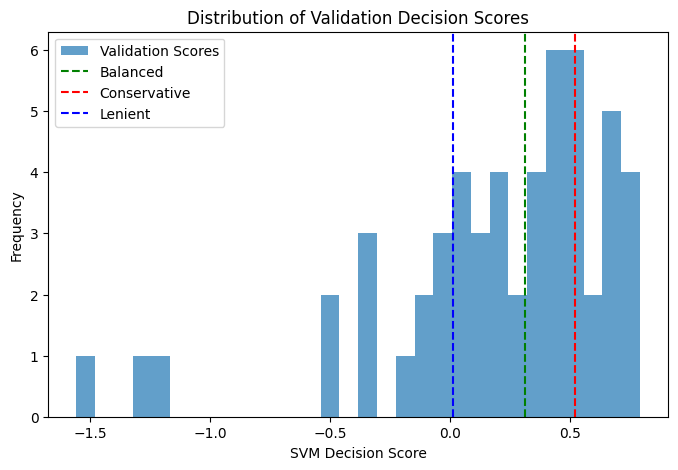

2025-02-13 00:54:54,053 [INFO] Saving SVM model, scaler, and thresholds...
2025-02-13 00:54:54,061 [INFO] Training complete!


In [ ]:
import os
import logging
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import joblib
import matplotlib.pyplot as plt  # Optional: for plotting decision distribution
from sklearn.cluster import KMeans

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# Extract Features for SVM
# -------------------------------
def extract_and_scale_features(feature_extractor, rgb_features, flow_features, scaler=None, fit_scaler=False, batch_size=4):
    """
    Extract and scale features from both streams.
    
    Parameters:
      - feature_extractor: the model used for feature extraction.
      - rgb_features, flow_features: input arrays for each stream.
      - scaler: an existing StandardScaler (if available).
      - fit_scaler: if True, fit a new scaler to the features.
      - batch_size: batch size for prediction.
    
    Returns:
      - features_scaled: the scaled features.
      - scaler: the fitted scaler (if fit_scaler was True).
    """
    try:
        logging.info("Extracting features...")
        features = feature_extractor.predict(
            [rgb_features, flow_features],
            batch_size=batch_size,
            verbose=1
        )
    except Exception as e:
        logging.error("Error during feature extraction: %s", e)
        raise

    if fit_scaler:
        logging.info("Fitting and transforming features...")
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        return features_scaled, scaler
    elif scaler is not None:
        logging.info("Transforming features using existing scaler...")
        features_scaled = scaler.transform(features)
        return features_scaled
    else:
        logging.info("Returning raw features (no scaling applied).")
        return features

# -------------------------------
# Train SVM with Validation
# -------------------------------
def train_svm_with_validation(feature_extractor, rgb_train, flow_train, rgb_val, flow_val, nu=0.1, batch_size=4):
    """
    Enhanced SVM training with improved threshold selection and validation.
    """
    # Extract and scale training features
    train_features_scaled, scaler = extract_and_scale_features(
        feature_extractor,
        rgb_train,
        flow_train,
        scaler=None,
        fit_scaler=True,
        batch_size=batch_size
    )
    
    # Calculate optimal nu using validation set
    logging.info("Calculating optimal nu parameter...")
    nu_range = np.linspace(0.01, 0.5, 20)
    best_nu = nu
    best_score = float('-inf')
    
    for nu_candidate in nu_range:
        svm_candidate = OneClassSVM(kernel='rbf', nu=nu_candidate, gamma='scale')
        svm_candidate.fit(train_features_scaled)
        
        # Get validation scores
        val_features_scaled = extract_and_scale_features(
            feature_extractor,
            rgb_val,
            flow_val,
            scaler=scaler,
            fit_scaler=False,
            batch_size=batch_size
        )
        val_scores = svm_candidate.decision_function(val_features_scaled)
        
        # Use interquartile range as a metric for separation
        score = np.percentile(val_scores, 75) - np.percentile(val_scores, 25)
        if score > best_score:
            best_score = score
            best_nu = nu_candidate
    
    logging.info(f"Selected optimal nu: {best_nu}")
    
    # Train final SVM with optimal nu
    svm = OneClassSVM(kernel='rbf', nu=best_nu, gamma='scale')
    svm.fit(train_features_scaled)
    
    # Extract and scale validation features
    val_features_scaled = extract_and_scale_features(
        feature_extractor,
        rgb_val,
        flow_val,
        scaler=scaler,
        fit_scaler=False,
        batch_size=batch_size
    )
    
    # Calculate decision function scores on validation set
    val_scores = svm.decision_function(val_features_scaled)
    
    # Use more robust threshold selection
    # Balanced: Use Otsu's method to find optimal threshold
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(val_scores.reshape(-1, 1))
    balanced_threshold = np.mean([
        np.max(val_scores[kmeans.labels_ == 0]),
        np.min(val_scores[kmeans.labels_ == 1])
    ])
    
    # Conservative: Use 90th percentile for higher precision
    conservative_threshold = np.percentile(val_scores, 90)
    
    # Lenient: Use 10th percentile for higher recall
    lenient_threshold = np.percentile(val_scores, 10)
    
    logging.info("Thresholds calculated:")
    logging.info("- Balanced: %.3f", balanced_threshold)
    logging.info("- Conservative: %.3f", conservative_threshold)
    logging.info("- Lenient: %.3f", lenient_threshold)
    
    return svm, scaler, {
        'balanced': balanced_threshold,
        'conservative': conservative_threshold,
        'lenient': lenient_threshold  # Fixed: Changed 'threshold' to 'lenient_threshold'
    }

def predict_with_confidence(svm, scaler, features, thresholds):
    """
    Make predictions with confidence scores.
    """
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Get decision scores
    scores = svm.decision_function(features_scaled)
    
    # Calculate predictions for each threshold
    predictions = {
        'lenient': scores >= thresholds['lenient'],
        'balanced': scores >= thresholds['balanced'],
        'conservative': scores >= thresholds['conservative']
    }
    
    # Calculate confidence scores (normalized distance from threshold)
    confidence_scores = {
        threshold_type: np.abs(scores - threshold_value) / np.max(np.abs(scores))
        for threshold_type, threshold_value in thresholds.items()
    }
    
    return predictions, confidence_scores, scores

# -------------------------------
# Optional: Plot Decision Distribution
# -------------------------------
def plot_decision_distribution(val_scores, thresholds):
    plt.figure(figsize=(8, 5))
    plt.hist(val_scores, bins=30, alpha=0.7, label='Validation Scores')
    plt.axvline(thresholds['balanced'], color='green', linestyle='--', label='Balanced')
    plt.axvline(thresholds['conservative'], color='red', linestyle='--', label='Conservative')
    plt.axvline(thresholds['lenient'], color='blue', linestyle='--', label='Lenient')
    plt.xlabel("SVM Decision Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Distribution of Validation Decision Scores")
    plt.show()

# -------------------------------
# Main Training Process
# -------------------------------
def main_training_process(feature_extractor, rgb_train, flow_train, rgb_val, flow_val, nu=0.1, batch_size=4):
    logging.info("Starting SVM training process...")
    
    # Train SVM with validation
    svm, scaler, thresholds = train_svm_with_validation(
        feature_extractor=feature_extractor,
        rgb_train=rgb_train,
        flow_train=flow_train,
        rgb_val=rgb_val,
        flow_val=flow_val,
        nu=nu,
        batch_size=batch_size
    )
    
    # Optional: plot decision distribution for inspection.
    try:
        val_features_scaled = extract_and_scale_features(
            feature_extractor, rgb_val, flow_val, scaler=scaler, fit_scaler=False, batch_size=batch_size)
        val_scores = svm.decision_function(val_features_scaled)
        plot_decision_distribution(val_scores, thresholds)
    except Exception as e:
        logging.warning("Could not plot decision distribution: %s", e)
    
    # Save models and thresholds
    logging.info("Saving SVM model, scaler, and thresholds...")
    joblib.dump(svm, "svm_model.joblib")
    joblib.dump(scaler, "scaler.joblib")
    np.save("svm_thresholds.npy", thresholds)
    
    logging.info("Training complete!")
    return svm, scaler, thresholds

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    # At this point, you should have defined:
    #   - feature_extractor
    #   - rgb_train, flow_train (your training data)
    #   - rgb_val, flow_val (your validation data)
    #
    # For example, you might have:
    #   from your_data_module import rgb_train, flow_train, rgb_val, flow_val
    #   from your_model_module import create_late_fusion_feature_extractor, create_rgb_stream_model, create_optical_flow_stream_model
    #   feature_extractor = create_late_fusion_feature_extractor(create_rgb_stream_model(), create_optical_flow_stream_model())
    
    # Run the training process (replace parameters if needed)
    svm, scaler, thresholds = main_training_process(
        feature_extractor=feature_extractor,
        rgb_train=features_train1,
        flow_train=features_train2,
        rgb_val=features_val1,
        flow_val=features_val2,
        nu=0.1,
        batch_size=4
    )


## Evaluate Model

17/17 [==============================] - 4s 87ms/step - loss: 0.2338 - accuracy: 0.9552
Test Loss: 0.2338
Test Accuracy: 0.9552
17/17 [==============================] - 2s 53ms/step


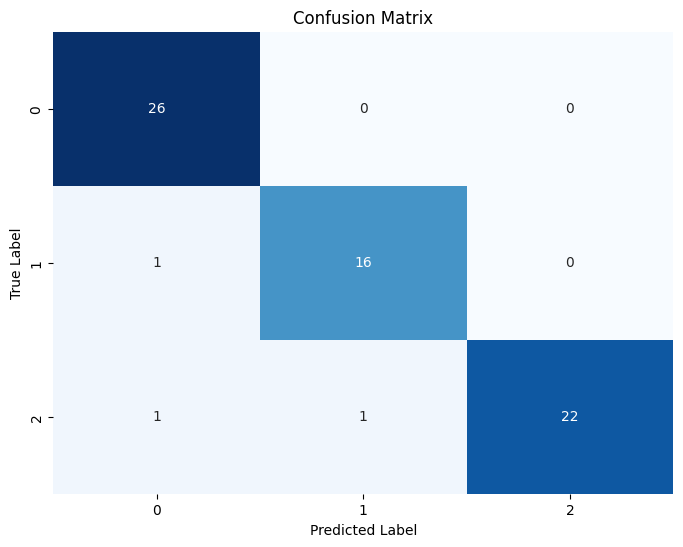

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       0.94      0.94      0.94        17
           2       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67



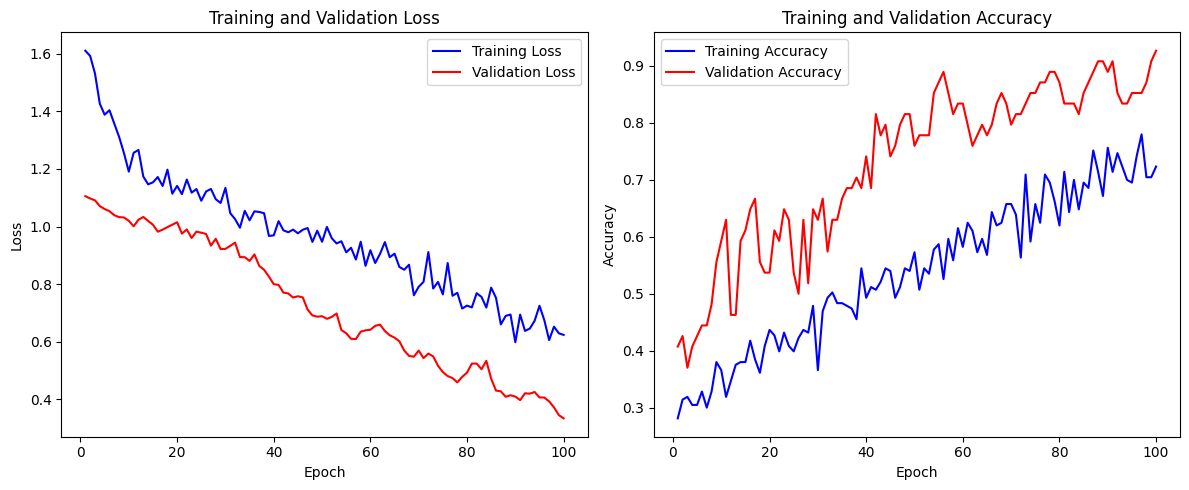

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# 1. Create a tf.data.Dataset for Evaluation
# ----------------------------
# Use a very small batch size during evaluation to avoid out-of-memory errors.
batch_size_eval = 4  # Adjust this value as necessary

# Wrap the test data in a tf.data.Dataset (this keeps only one batch in memory at a time)
test_dataset = tf.data.Dataset.from_tensor_slices(((features_test1, features_test2), labels_test1))
test_dataset = test_dataset.batch(batch_size_eval).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# 2. Evaluate the Model on the Test Set
# ----------------------------
test_loss, test_accuracy = late_fusion_model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ----------------------------
# 3. Generate Predictions and Plot the Confusion Matrix
# ----------------------------
# Predict on the test dataset
y_pred = late_fusion_model.predict(test_dataset)

# Convert predictions from softmax output to class indices
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true one-hot encoded labels to class indices
y_true = np.argmax(labels_test1, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
report = classification_report(y_true, y_pred_labels)
print("Classification Report:\n", report)

# ----------------------------
# 4. Plot Training Curves (Loss and Accuracy)
# ----------------------------
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### New Training


In [ ]:
# -------------------------------
# Extract Features for SVM
# -------------------------------
def extract_and_scale_features(feature_extractor, rgb_features, flow_features, scaler=None, fit_scaler=False):
    """Extract and scale features from both streams."""
    print("Extracting features...")
    features = feature_extractor.predict(
        [rgb_features, flow_features],
        batch_size=4,
        verbose=1
    )
    
    if fit_scaler:
        print("Fitting and transforming features...")
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        return features_scaled, scaler
    elif scaler is not None:
        print("Transforming features...")
        features_scaled = scaler.transform(features)
        return features_scaled
    else:
        return features

# -------------------------------
# Train SVM
# -------------------------------
def train_svm_with_validation(feature_extractor, rgb_train, flow_train, rgb_val, flow_val, nu=0.1):
    """Train SVM with validation-based threshold selection."""
    # Extract and scale training features
    train_features_scaled, scaler = extract_and_scale_features(
        feature_extractor,
        rgb_train,
        flow_train,
        fit_scaler=True
    )
    
    # Train SVM
    print("Training One-Class SVM...")
    svm = OneClassSVM(
        kernel='rbf',
        nu=nu,
        gamma='scale'
    )
    svm.fit(train_features_scaled)
    
    # Extract and scale validation features
    val_features_scaled = extract_and_scale_features(
        feature_extractor,
        rgb_val,
        flow_val,
        scaler=scaler
    )
    
    # Calculate decision function scores on validation set
    val_scores = svm.decision_function(val_features_scaled)
    
    # Calculate different thresholds
    balanced_threshold = np.median(val_scores)
    conservative_threshold = np.percentile(val_scores, 75)  # More strict
    lenient_threshold = np.percentile(val_scores, 25)      # More lenient
    
    print(f"Thresholds calculated:")
    print(f"- Balanced: {balanced_threshold:.3f}")
    print(f"- Conservative: {conservative_threshold:.3f}")
    print(f"- Lenient: {lenient_threshold:.3f}")
    
    return svm, scaler, {
        'balanced': balanced_threshold,
        'conservative': conservative_threshold,
        'lenient': lenient_threshold
    }

# -------------------------------
# Main Training Process
# -------------------------------
print("Starting SVM training process...")

# Train SVM with validation
svm, scaler, thresholds = train_svm_with_validation(
    feature_extractor=feature_extractor,
    rgb_train=features_train1,
    flow_train=features_train2,
    rgb_val=features_val1,
    flow_val=features_val2,
    nu=0.1  # Try different values (0.05, 0.1, 0.15)
)

# Save models and thresholds
print("Saving models and thresholds...")
joblib.dump(svm, "svm_model.joblib")
joblib.dump(scaler, "scaler.joblib")
np.save("svm_thresholds.npy", thresholds)

print("Training complete!")

## Inference

In [42]:
import cv2
import numpy as np
import tensorflow as tf

# ----------------------------
# Define your class names
# ----------------------------
CLASSES_LIST = ['LumbarSideBends', 'QuadrupedThoracicRotation', 'SupineNeckLift']

# ----------------------------
# Optical Flow Functions (Lucas-Kanade)
# ----------------------------
def compute_optical_flow(prev_frame, next_frame):
    """
    Compute optical flow using the Lucas-Kanade method between two frames.
    
    Returns:
        good_old: Array of points from the previous frame.
        good_new: Array of corresponding points from the next frame.
    """
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Parameters for Shi-Tomasi corner detection (good features to track)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    
    # Detect features in the previous frame
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []

    # Calculate optical flow (find corresponding points in the next frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Ensure valid output and select good points based on the status array
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    """
    Create Motion Energy Image (MEI) and Motion History Image (MHI) from optical flow vectors.
    
    Args:
        flow: Tuple containing (good_old, good_new) points.
        shape: Tuple defining the output image size (height, width).
        tau: Time constant for motion decay in the MHI.
        
    Returns:
        mei: The Motion Energy Image (binary representation of motion).
        mhi: The Motion History Image (captures motion intensity with decay).
    """
    # Initialize MEI and MHI as zero arrays
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)

    # Iterate over each pair of corresponding points to draw motion vectors
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw motion on MEI (binary)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw motion on MHI (with intensity)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Decay MHI over time
    mhi[mhi > 0] -= 255 / tau  
    mhi[mhi < 0] = 0

    return mei, mhi

# ----------------------------
# Define Optical Flow Sequence Using Lucas-Kanade
# ----------------------------
def compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10):
    """
    For a list of frames, resize them to target_size (which is in (width, height) order),
    compute Lucas-Kanade optical flow between consecutive frames, and use create_mei_mhi
    to obtain a Motion Energy Image (MEI). The MEI is normalized to [0,1].
    
    Returns a numpy array of shape (num_frames, target_height, target_width, 1).
    """
    # First, resize frames for optical flow computation.
    # target_size is (width, height); output images will have shape (height, width).
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        resized_frames.append(resized)
    
    flow_sequence = []
    for i in range(len(resized_frames) - 1):
        prev_frame = resized_frames[i]
        next_frame = resized_frames[i + 1]
        good_old, good_new = compute_optical_flow(prev_frame, next_frame)
        if len(good_old) == 0 or len(good_new) == 0:
            # If no flow is detected, use a zero image
            mei = np.zeros((target_size[1], target_size[0]), dtype=np.float32)
        else:
            mei, _ = create_mei_mhi((good_old, good_new), (target_size[1], target_size[0]), tau=tau)
            # Normalize the MEI from 0 to 1
            mei = mei / 255.0
        # Expand dims to add the channel dimension (resulting shape: (height, width, 1))
        mei = np.expand_dims(mei, axis=-1)
        flow_sequence.append(mei.astype(np.float32))
    
    # Optical flow computed from N frames gives N-1 flow images.
    # Pad the sequence with a zero frame to match the number of frames.
    desired_length = len(frames)
    while len(flow_sequence) < desired_length:
        zero_frame = np.zeros((target_size[1], target_size[0], 1), dtype=np.float32)
        flow_sequence.append(zero_frame)
    
    return np.array(flow_sequence)

# ----------------------------
# RGB Preprocessing Function
# ----------------------------
def preprocess_rgb_frames(frames, target_size=(96, 96)):
    """
    For each frame:
      - Resize to target_size (using (width, height) order),
      - Convert from BGR to RGB,
      - Normalize pixel values to [0, 1].
    Returns a numpy array of shape (num_frames, target_height, target_width, 3).
    """
    rgb_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb_frames.append(rgb)
    return np.array(rgb_frames)

# ----------------------------
# Frame Sampling Function
# ----------------------------
def sample_frames_from_video(video_path, num_frames):
    """
    Samples `num_frames` uniformly from the input video.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print("Warning: Video has fewer frames than requested; using available frames.")
        num_frames = total_frames
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    current_index = 0
    ret = True
    while ret and current_index < total_frames:
        ret, frame = cap.read()
        if current_index in indices:
            frames.append(frame)
        current_index += 1
    cap.release()
    return frames

# ----------------------------
# New Function: Ensure Video Resolution
# ----------------------------
def ensure_video_resolution(frames, target_size=(320, 240)):
    """
    Ensures that each frame in the list is resized to the specified target resolution.
    
    Args:
        frames (list): List of video frames (numpy arrays).
        target_size (tuple): Desired resolution in (width, height) format.
        
    Returns:
        list: List of frames resized to target_size.
    """
    resized_frames = []
    for frame in frames:
        # Resize each frame to the target resolution (320x240)
        resized_frame = cv2.resize(frame, target_size)
        resized_frames.append(resized_frame)
    return resized_frames

# ----------------------------
# Inference Function
# ----------------------------
def run_inference_on_video(video_path, model, num_frames=30):
    """
    Loads a video from `video_path`, samples `num_frames` uniformly,
    ensures that each frame is set to 320x240 resolution,
    preprocesses the frames for both the RGB and optical flow streams,
    and runs inference using the provided model.
    
    Returns the predicted class index and prediction probabilities.
    """
    # Sample frames from the video.
    frames = sample_frames_from_video(video_path, num_frames)
    if len(frames) < num_frames:
        print("Error: Not enough frames in the video for inference.")
        return None, None

    # Ensure all frames are resized to 320x240 resolution.
    frames = ensure_video_resolution(frames, target_size=(320, 240))
    
    # Preprocess frames for the RGB stream.
    rgb_sequence = preprocess_rgb_frames(frames, target_size=(96, 96))
    
    # Preprocess frames for the optical flow stream.
    # Note: Here the optical flow function resizes the frames again to its target_size.
    # You may adjust the target_size here if needed.
    flow_sequence = compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10)
    
    # Add a batch dimension: final shapes become:
    # rgb_input: (1, num_frames, target_height, target_width, 3)
    # flow_input: (1, num_frames, target_height, target_width, 1)
    rgb_input = np.expand_dims(rgb_sequence, axis=0)
    flow_input = np.expand_dims(flow_sequence, axis=0)
    
    # Run model inference.
    predictions = model.predict([rgb_input, flow_input])
    pred_class = np.argmax(predictions, axis=1)[0]
    return pred_class, predictions

# ----------------------------
# Main Inference Script
# ----------------------------
if __name__ == "__main__":
    video_path = input("Enter the path to the video file for inference: ").strip()
    
    # Load the late fusion model from the specified path.
    model_path = r"D:\MAPUA\CNN_GRU_usingRGBOF\late_fusion_model_trained.h5"
    late_fusion_model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
    
    predicted_class, probs = run_inference_on_video(video_path, late_fusion_model, num_frames=30)
    
    if predicted_class is not None:
        # Retrieve the class name and compute the confidence percentage.
        predicted_class_name = CLASSES_LIST[predicted_class]
        confidence_percentage = probs[0][predicted_class] * 100  # Convert to percentage
        print(f"Predicted Class: {predicted_class_name} with {confidence_percentage:.2f}% confidence.")


Loaded model from D:\MAPUA\CNN_GRU_usingRGBOF\late_fusion_model_trained.h5
1/1 [==============================] - 2s 2s/step
Predicted Class: QuadrupedThoracicRotation with 88.37% confidence.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, GRU, Dropout, Dense, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

# --- Constants ---
CLASSES_LIST = ['LumbarSideBends', 'QuadrupedThoracicRotation', 'SupineNeckLift']
IMAGE_HEIGHT, IMAGE_WIDTH = 96, 96
SEQUENCE_LENGTH = 30

# --- Function Definitions (Keep these as they are) ---

def compute_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []
    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        mhi[mhi > 0] -= 255 / tau
        mhi[mhi < 0] = 0
    return mei, mhi

def compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10):
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        resized_frames.append(resized)
    flow_sequence = []
    for i in range(len(resized_frames) - 1):
        prev_frame = resized_frames[i]
        next_frame = resized_frames[i + 1]
        good_old, good_new = compute_optical_flow(prev_frame, next_frame)
        if len(good_old) == 0 or len(good_new) == 0:
            mei = np.zeros((target_size[1], target_size[0]), dtype=np.float32)
        else:
            mei, _ = create_mei_mhi((good_old, good_new), (target_size[1], target_size[0]), tau=tau)
        mei = mei / 255.0
        mei = np.expand_dims(mei, axis=-1)
        flow_sequence.append(mei.astype(np.float32))
    desired_length = len(frames)
    while len(flow_sequence) < desired_length:
        zero_frame = np.zeros((target_size[1], target_size[0], 1), dtype=np.float32)
        flow_sequence.append(zero_frame)
    return np.array(flow_sequence)

def preprocess_rgb_frames(frames, target_size=(96, 96)):
    rgb_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb_frames.append(rgb)
    return np.array(rgb_frames)

def sample_frames_from_video(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print("Warning: Video has fewer frames than requested; using available frames.")
        num_frames = total_frames
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    current_index = 0
    ret = True
    while ret and current_index < total_frames:
        ret, frame = cap.read()
        if current_index in indices:
            frames.append(frame)
        current_index += 1
    cap.release()
    return frames

def ensure_video_resolution(frames, target_size=(320, 240)):
    resized_frames = []
    for frame in frames:
        # Resize each frame to the target resolution (320x240)
        resized_frame = cv2.resize(frame, target_size)
        resized_frames.append(resized_frame)
    return resized_frames

def predict_with_svm(feature_extractor, features1, features2, svm, scaler, threshold=0):
    """
    Predicts whether a video is "unseen" or "known" using the SVM.

    Args:
        feature_extractor: The Keras feature extractor model.
        features1:  RGB features (single video) - shape (seq_len, H, W, C).
        features2:  Optical Flow features (single video) - shape (seq_len, H, W, 1).
        svm: The trained One-Class SVM.
        scaler:  The fitted StandardScaler.
        threshold:  Decision threshold.  Values *below* this are considered "unseen".

    Returns:
        "unseen" or "known"
    """
    # Add a batch dimension
    features1 = np.expand_dims(features1, axis=0)  # (1, seq_len, H, W, C)
    features2 = np.expand_dims(features2, axis=0)  # (1, seq_len, H, W, 1)

    # Extract features
    features = feature_extractor.predict([features1, features2], verbose=0)

    # Scale features
    features_scaled = scaler.transform(features)

    # Get SVM decision function output (distance from hyperplane)
    decision = svm.decision_function(features_scaled)

    # Classify based on threshold
    if decision[0] > threshold:
        return "known"
    else:
        return "unseen"

# --- Modified Inference Function ---
def run_inference_on_video_svm_and_classify(video_path, feature_extractor, late_fusion_model, svm, scaler, num_frames=30, threshold=0):
    """
    Loads a video, preprocesses it, uses SVM for novelty detection,
    and if classified as "known", uses the late fusion model for classification.
    """
    frames = sample_frames_from_video(video_path, num_frames)
    if len(frames) < num_frames:
        print("Error: Not enough frames in the video for inference.")
        return None, None, None  # Return None for class, confidence, and novelty

    frames = ensure_video_resolution(frames, target_size=(320, 240))
    rgb_sequence = preprocess_rgb_frames(frames, target_size=(96, 96))
    flow_sequence = compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10)

    # 1. Novelty Detection (SVM)
    novelty = predict_with_svm(feature_extractor, rgb_sequence, flow_sequence, svm, scaler, threshold)

    if novelty == "unseen":
        return None, None, "unseen"  # Return None for class/confidence, but "unseen" for novelty
    else:
        # 2. Classification (Late Fusion Model) - Only if NOT unseen
        rgb_input = np.expand_dims(rgb_sequence, axis=0)  # (1, seq_len, H, W, C)
        flow_input = np.expand_dims(flow_sequence, axis=0)  # (1, seq_len, H, W, 1)
        predictions = late_fusion_model.predict([rgb_input, flow_input], verbose=0)
        pred_class = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions) * 100  # Convert to percentage

        return pred_class, confidence, "known"

# --- Main Inference Script ---
if __name__ == '__main__':
    # --- Load Trained Models ---
    # 1. Feature Extractor (Keras Model)
    # Re-create the feature_extractor:
    def create_rgb_stream_model(seq_length=30, input_shape=(96, 96, 3), gru_units=64, dropout_rate=0.5, feature_dim=64):
      base_cnn = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
      base_cnn.trainable = False
      rgb_input = Input(shape=(seq_length,) + input_shape, name="rgb_input")
      x = TimeDistributed(base_cnn, name="time_distributed_cnn")(rgb_input)
      x = TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_gap")(x)
      x = GRU(gru_units, return_sequences=False, name="gru_layer")(x)
      x = Dropout(dropout_rate, name="gru_dropout")(x)
      output = Dense(feature_dim, activation='relu', name="rgb_feature_vector")(x)
      model = Model(inputs=rgb_input, outputs=output, name="RGB_Stream_Model")
      return model

    def create_optical_flow_stream_model(seq_length=30, input_shape=(320, 240, 1), gru_units=64, dropout_rate=0.5, feature_dim=64):
        flow_input = Input(shape=(seq_length,) + input_shape, name="flow_input")
        x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), name="td_conv1")(flow_input)
        x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool1")(x)
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), name="td_conv2")(x)
        x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool2")(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name="td_conv3")(x)
        x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool3")(x)
        x = TimeDistributed(GlobalAveragePooling2D(), name="td_gap")(x)
        x = GRU(gru_units, return_sequences=False, name="gru_flow")(x)
        x = Dropout(dropout_rate, name="gru_flow_dropout")(x)
        output = Dense(feature_dim, activation='relu', name="flow_feature_vector")(x)
        model = Model(inputs=flow_input, outputs=output, name="OpticalFlow_Stream_Model")
        return model

    def create_late_fusion_feature_extractor(rgb_model, optical_flow_model):
      rgb_input = rgb_model.input
      flow_input = optical_flow_model.input
      rgb_features = rgb_model.output
      flow_features = optical_flow_model.output
      rgb_features = BatchNormalization(name="rgb_bn")(rgb_features)
      flow_features = BatchNormalization(name="flow_bn")(flow_features)
      fused_features = Concatenate(name='fusion_concat')([rgb_features, flow_features])
      feature_extractor = Model(inputs=[rgb_input, flow_input], outputs=fused_features, name='feature_extractor')
      return feature_extractor

    rgb_model = create_rgb_stream_model()
    optical_flow_model = create_optical_flow_stream_model()
    feature_extractor = create_late_fusion_feature_extractor(rgb_model, optical_flow_model)

    # 2. One-Class SVM
    svm = joblib.load("svm_model.joblib")

    # 3. Scaler
    scaler = joblib.load("scaler.joblib")

    #4. Late Fusion Model
    late_fusion_model = tf.keras.models.load_model('late_fusion_model_trained.h5')

    # --- Get Video Path (User Input) ---
    video_path = input("Enter the path to the video file: ")

    # --- Run Inference and Print Result ---
    threshold = -5  # Adjust this threshold! Use a validation set.

    predicted_class_index, confidence, novelty = run_inference_on_video_svm_and_classify(
        video_path, feature_extractor, late_fusion_model, svm, scaler, num_frames=SEQUENCE_LENGTH, threshold=threshold
    )

    if novelty == "unseen":
        print("Prediction: Unseen/Novel Video")
    else:
        predicted_class_name = CLASSES_LIST[predicted_class_index]
        print(f"Prediction: Known video - {predicted_class_name} ({confidence:.2f}%)")

Prediction: Known video - LumbarSideBends (74.79%)


#UPDATED INFERENCE


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model

# Constants
CLASSES_LIST = ['LumbarSideBends', 'QuadrupedThoracicRotation', 'SupineNeckLift']
IMAGE_HEIGHT, IMAGE_WIDTH = 96, 96
SEQUENCE_LENGTH = 30

def ensure_video_resolution(frames, target_size=(320, 240)):
    """
    Ensures that each frame in the list is resized to the specified target resolution.
    
    Args:
        frames (list): List of video frames (numpy arrays).
        target_size (tuple): Desired resolution in (width, height) format.
        
    Returns:
        list: List of frames resized to target_size.
    """
    resized_frames = []
    for frame in frames:
        # Resize each frame to the target resolution (320x240)
        resized_frame = cv2.resize(frame, target_size)
        resized_frames.append(resized_frame)
    return resized_frames

def sample_frames_from_video(video_path, num_frames):
    """
    Samples `num_frames` uniformly from the input video.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print("Warning: Video has fewer frames than requested; using available frames.")
        num_frames = total_frames
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    current_index = 0
    ret = True
    while ret and current_index < total_frames:
        ret, frame = cap.read()
        if current_index in indices:
            frames.append(frame)
        current_index += 1
    cap.release()
    return frames

def compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10):
    """
    For a list of frames, resize them to target_size (which is in (width, height) order),
    compute Lucas-Kanade optical flow between consecutive frames, and use create_mei_mhi
    to obtain a Motion Energy Image (MEI). The MEI is normalized to [0,1].
    
    Returns a numpy array of shape (num_frames, target_height, target_width, 1).
    """
    # First, resize frames for optical flow computation.
    # target_size is (width, height); output images will have shape (height, width).
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        resized_frames.append(resized)
    
    flow_sequence = []
    for i in range(len(resized_frames) - 1):
        prev_frame = resized_frames[i]
        next_frame = resized_frames[i + 1]
        good_old, good_new = compute_optical_flow(prev_frame, next_frame)
        if len(good_old) == 0 or len(good_new) == 0:
            # If no flow is detected, use a zero image
            mei = np.zeros((target_size[1], target_size[0]), dtype=np.float32)
        else:
            mei, _ = create_mei_mhi((good_old, good_new), (target_size[1], target_size[0]), tau=tau)
            # Normalize the MEI from 0 to 1
            mei = mei / 255.0
        # Expand dims to add the channel dimension (resulting shape: (height, width, 1))
        mei = np.expand_dims(mei, axis=-1)
        flow_sequence.append(mei.astype(np.float32))
    
    # Optical flow computed from N frames gives N-1 flow images.
    # Pad the sequence with a zero frame to match the number of frames.
    desired_length = len(frames)
    while len(flow_sequence) < desired_length:
        zero_frame = np.zeros((target_size[1], target_size[0], 1), dtype=np.float32)
        flow_sequence.append(zero_frame)
    
    return np.array(flow_sequence)

def preprocess_rgb_frames(frames, target_size=(96, 96)):
    """
    For each frame:
      - Resize to target_size (using (width, height) order),
      - Convert from BGR to RGB,
      - Normalize pixel values to [0, 1].
    Returns a numpy array of shape (num_frames, target_height, target_width, 3).
    """
    rgb_frames = []
    for frame in frames:
        resized = cv2.resize(frame, target_size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb_frames.append(rgb)
    return np.array(rgb_frames)


def predict_with_svm(feature_extractor, features1, features2, svm, scaler, threshold_type='conservative'):
    """
    Predicts whether a video is "unseen" or "known" using the SVM with different threshold options.
    
    Args:
        feature_extractor: The feature extraction model
        features1: RGB features (single video)
        features2: Optical flow features (single video)
        svm: Trained One-Class SVM
        scaler: Fitted StandardScaler
        threshold_type: One of 'balanced', 'conservative', or 'lenient'
    
    Returns:
        "unseen" or "known"
    """
    # Add batch dimension if needed
    if len(features1.shape) == 4:
        features1 = np.expand_dims(features1, axis=0)
    if len(features2.shape) == 4:
        features2 = np.expand_dims(features2, axis=0)
    
    # Extract features using the feature extractor
    features = feature_extractor.predict([features1, features2], verbose=0)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Get SVM decision score
    decision = svm.decision_function(features_scaled)
    
    # Load thresholds
    thresholds = np.load("svm_thresholds.npy", allow_pickle=True).item()
    threshold = thresholds[threshold_type]
    
    return "known" if decision[0] > threshold else "unseen"

def run_inference_on_video(video_path, feature_extractor, late_fusion_model, svm, scaler, 
                           threshold_type='conservative', confidence_threshold=0.8):
    """
    Complete inference pipeline for video classification with novelty detection.
    """
    # Sample frames from the video.
    frames = sample_frames_from_video(video_path, SEQUENCE_LENGTH)
    if len(frames) < SEQUENCE_LENGTH:
        return {
            'status': 'error',
            'message': 'Not enough frames in video',
            'class': None,
            'confidence': None,
            'novelty': None
        }
    
    # Ensure frames are at the desired resolution.
    frames = ensure_video_resolution(frames, target_size=(320, 240))
    
    # Prepare input sequences.
    rgb_sequence = preprocess_rgb_frames(frames, target_size=(96, 96))
    flow_sequence = compute_optical_flow_sequence_lk(frames, target_size=(240, 320), tau=10)
    
    # Novelty detection using the SVM.
    novelty = predict_with_svm(feature_extractor, rgb_sequence, flow_sequence, svm, scaler, threshold_type)
    if novelty == "unseen":
        return {
            'status': 'success',
            'class': None,
            'confidence': None,
            'novelty': 'unseen'
        }
    
    # If known, perform classification.
    rgb_input = np.expand_dims(rgb_sequence, axis=0)
    flow_input = np.expand_dims(flow_sequence, axis=0)
    predictions = late_fusion_model.predict([rgb_input, flow_input], verbose=0)
    confidence = float(np.max(predictions)) * 100
    
    # DEBUG: print classification confidence.
    print(f"[DEBUG] Classification confidence: {confidence:.2f}%")
    
    # Check the confidence threshold.
    if confidence < confidence_threshold * 100:
        return {
            'status': 'success',
            'class': None,
            'confidence': confidence,
            'novelty': 'unseen_low_confidence'
        }
    
    predicted_class_index = int(np.argmax(predictions, axis=1)[0])
    predicted_class = CLASSES_LIST[predicted_class_index]
    
    return {
        'status': 'success',
        'class': predicted_class,
        'confidence': confidence,
        'novelty': 'known'
    }

# Main execution
if __name__ == "__main__":
    # Load models
    print("Loading models...")
    feature_extractor = create_late_fusion_feature_extractor(
        create_rgb_stream_model(),
        create_optical_flow_stream_model()
    )
    late_fusion_model = load_model('late_fusion_model_trained.h5')
    svm = joblib.load("svm_model.joblib")
    scaler = joblib.load("scaler.joblib")
    
    # Get video path
    video_path = input("Enter the path to the video file: ")
    
    # Run inference
    result = run_inference_on_video(
        video_path,
        feature_extractor,
        late_fusion_model,
        svm,
        scaler,
        threshold_type='lenient',  # Use conservative threshold for better unknown detection
        confidence_threshold=0.8  # Adjust this threshold as needed
    )
    
    # Print results
    if result['status'] == 'error':
        print(f"Error: {result['message']}")
    else:
        if result['novelty'] == 'unseen':
            print("Prediction: Unknown Exercise Type")
        elif result['novelty'] == 'unseen_low_confidence':
            print(f"Prediction: Unknown Exercise Type (Low confidence: {result['confidence']:.2f}%)")
        else:
            print(f"Prediction: {result['class']} ({result['confidence']:.2f}%)")

Loading models...
Prediction: Unknown Exercise Type


UPDATED ITO